## Set up

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import lightning.pytorch as pl
import torch
import pickle
import xgboost as xgb
import optuna

from datetime import datetime, timedelta
from tqdm import tqdm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import mean_squared_error, make_scorer

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

In [33]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Import the data

In [34]:
online_retail_df = pd.read_json('../../dataset/online_retail_data/online_retail.json')
online_retail_df

,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.65
...,...,...,...,...,...
73299,heart of wicker large,2010-12-05,94,261.30,2.78
73300,heart of wicker large,2010-12-06,34,118.06,3.47
73301,heart of wicker large,2010-12-07,462,1451.10,3.14
73302,heart of wicker large,2010-12-08,35,106.21,3.03


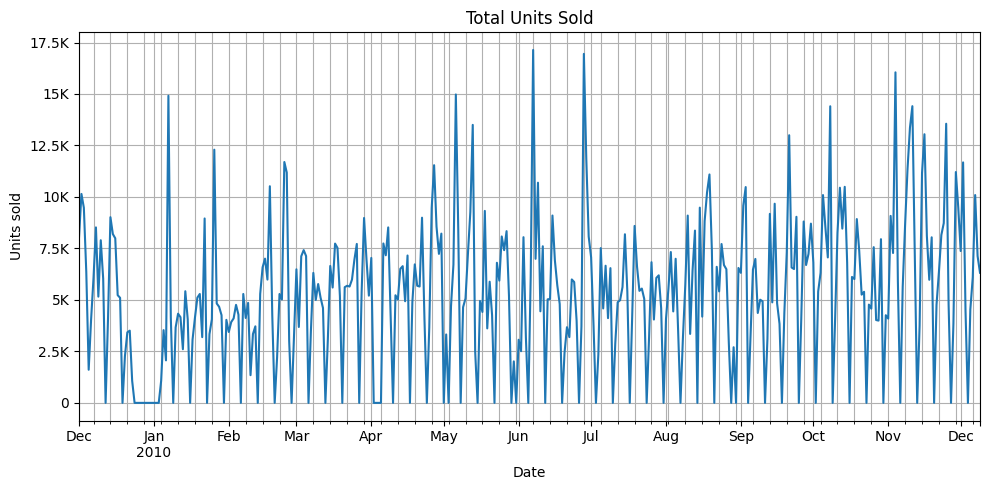

In [35]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['UnitsSold'].sum().plot(ax=ax)

ax.set_title('Total Units Sold')
ax.set_xlabel('Date')
ax.set_ylabel('Units sold')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

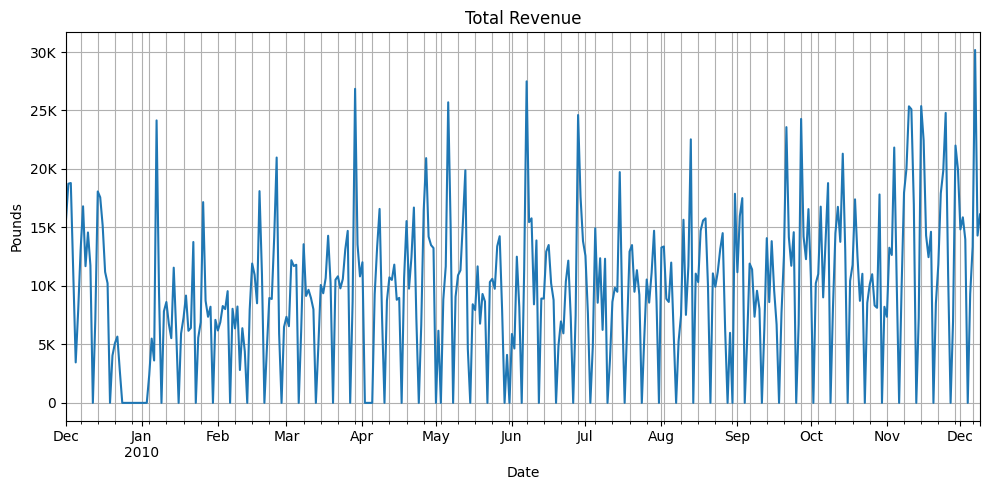

In [36]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['RevenuePounds'].sum().plot(ax=ax)

ax.set_title('Total Revenue')
ax.set_xlabel('Date')
ax.set_ylabel('Pounds')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

## Prepare the data

In [67]:
feature_dataset_df = online_retail_df[['Description', 'Date', 'UnitsSold', 'AveragePricePerUnitPounds', 'RevenuePounds']].copy()
feature_dataset_df['DayOfWeek_Str'] = feature_dataset_df['Date'].dt.day_name()

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

feature_dataset_df['DayOfWeek_CatOrdered'] = pd.Categorical(
    feature_dataset_df['DayOfWeek_Str'], categories=ordered_days, ordered=True
)

feature_dataset_df['DayOfWeek_Numerical'] = feature_dataset_df['DayOfWeek_CatOrdered'].cat.codes

day_of_week_dummies_ordered = pd.get_dummies(
    feature_dataset_df['DayOfWeek_CatOrdered'], dtype=int
)

feature_dataset_df = pd.concat([feature_dataset_df, day_of_week_dummies_ordered], axis=1)
feature_dataset_df = feature_dataset_df.drop(columns=[
    'DayOfWeek_Str',
    'DayOfWeek_CatOrdered',
])

feature_dataset_df['DayOfMonth'] = feature_dataset_df['Date'].dt.day

feature_dataset_df['IsWeekend'] = (feature_dataset_df['Date'].dt.weekday >= 5).astype(int)

group = feature_dataset_df.groupby('Description')

feature_dataset_df['DayBefore'] = group['UnitsSold'].shift(1)
feature_dataset_df['TwoDaysBefore'] = group['UnitsSold'].shift(2)
feature_dataset_df['WeekBefore'] = group['UnitsSold'].shift(7)
feature_dataset_df['MonthBefore'] = group['UnitsSold'].shift(30)

feature_dataset_df['Rolling3Mean'] = group['UnitsSold'].shift(1).rolling(3).mean()
feature_dataset_df['Rolling7Mean'] = group['UnitsSold'].shift(1).rolling(7).mean()
feature_dataset_df['Rolling30Sum'] = group['UnitsSold'].shift(1).rolling(30).sum()

feature_dataset_df['Log1p_UnitsSold'] = np.log1p(feature_dataset_df['UnitsSold'])
feature_dataset_df['Log1p_AveragePrice'] = np.log1p(feature_dataset_df['AveragePricePerUnitPounds'])

feature_dataset_df['Price_x_IsWeekend'] = feature_dataset_df['AveragePricePerUnitPounds'] * feature_dataset_df['IsWeekend']
feature_dataset_df['LogPrice_x_DayBefore'] = feature_dataset_df['Log1p_AveragePrice'] * feature_dataset_df['DayBefore']

feature_dataset_df = feature_dataset_df.fillna(0)

feature_dataset_df = feature_dataset_df.sort_values(by=['Description', 'Date'])

feature_dataset_df

,Description,Date,UnitsSold,AveragePricePerUnitPounds,RevenuePounds,DayOfWeek_Numerical,Monday,Tuesday,Wednesday,Thursday,...,TwoDaysBefore,WeekBefore,MonthBefore,Rolling3Mean,Rolling7Mean,Rolling30Sum,Log1p_UnitsSold,Log1p_AveragePrice,Price_x_IsWeekend,LogPrice_x_DayBefore
0,12 pencils small tube red spotty,2009-12-01,45,0.66,29.90,1,0,1,0,0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,3.828641,0.506818,0.00,0.000000
1,12 pencils small tube red spotty,2009-12-02,87,0.71,61.75,2,0,0,1,0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,4.477337,0.536493,0.00,24.142202
2,12 pencils small tube red spotty,2009-12-03,34,0.69,23.40,3,0,0,0,1,...,45.0,0.0,0.0,0.000000,0.000000,0.0,3.555348,0.524729,0.00,45.651382
3,12 pencils small tube red spotty,2009-12-04,84,0.66,55.25,4,0,0,0,0,...,87.0,0.0,0.0,55.333333,0.000000,0.0,4.442651,0.506818,0.00,17.231798
4,12 pencils small tube red spotty,2009-12-05,0,0.65,0.00,5,0,0,0,0,...,34.0,0.0,0.0,68.333333,0.000000,0.0,0.000000,0.500775,0.65,42.065124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53477,zinc metal heart decoration,2010-12-05,34,1.25,42.50,6,0,0,0,0,...,6.0,54.0,1.0,14.000000,34.428571,1438.0,3.555348,0.810930,1.25,0.000000
53478,zinc metal heart decoration,2010-12-06,33,1.52,50.07,0,1,0,0,0,...,0.0,82.0,0.0,13.333333,31.571429,1471.0,3.526361,0.924259,0.00,31.424803
53479,zinc metal heart decoration,2010-12-07,51,1.27,65.01,1,0,1,0,0,...,34.0,36.0,33.0,22.333333,24.571429,1504.0,3.951244,0.819780,0.00,27.052734
53480,zinc metal heart decoration,2010-12-08,20,1.31,26.26,2,0,0,1,0,...,33.0,27.0,81.0,39.333333,26.714286,1522.0,3.044522,0.837248,0.00,42.699624


In [68]:
last_date = feature_dataset_df['Date'].max() - timedelta(days=60)
train_df = feature_dataset_df[lambda x: x['Date'] <= last_date]
val_df = feature_dataset_df[lambda x: x['Date'] > last_date]

## XGBoost tree

### Explore features and parameters

#### Find best features

In [84]:
features = [
    'AveragePricePerUnitPounds',
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'DayOfMonth',

    'DayBefore', 'TwoDaysBefore', 'WeekBefore', 'MonthBefore',

    'IsWeekend',

    'Rolling3Mean', 'Rolling7Mean', 'Rolling30Sum',

    'Log1p_AveragePrice',

    'Price_x_IsWeekend',
    'LogPrice_x_DayBefore'
]

target = 'UnitsSold'

In [85]:
product = 'pack of 72 retro spot cake cases'
product_train_df = train_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
product_val_df = val_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
X_train, y_train = product_train_df[features], product_train_df[target]
X_val, y_val = product_val_df[features], product_val_df[target]

In [86]:
def objective(trial):
    """Objective function for Optuna to minimize RMSE."""
    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-5, 1.0),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

In [87]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='minimize')  # We want to minimize RMSE
study.optimize(objective, n_trials=100, show_progress_bar=True)  # Adjust the number of trials as needed

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value (RMSE): ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


  0%|          | 0/100 [00:00<?, ?it/s]

Number of finished trials:  100
Best trial:
  Value (RMSE):  154.91168729109822
  Params: 
    n_estimators: 101
    learning_rate: 0.21203609354235647
    max_depth: 9
    min_child_weight: 2
    subsample: 0.9499526114043306
    colsample_bytree: 0.8001472955025266
    alpha: 0.7967170598575484
    lambda: 0.73640613052203


In [98]:
# Define sMAPE scorer
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

smape_scorer = make_scorer(smape, greater_is_better=False)

best_params = study.best_params

xgb_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', eval_metric='rmse', random_state=42)

# Feature selection
sfs = SFS(xgb_model,
          k_features='best',
          forward=True,
          floating=False,
          scoring=smape_scorer,
          cv=3,
          n_jobs=-1)

sfs = sfs.fit(X_train, y_train)

# Results
print("Selected features:", list(sfs.k_feature_names_))
print("Best sMAPE score (on CV):", -sfs.k_score_)

Selected features: ['AveragePricePerUnitPounds', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday', 'DayOfMonth', 'DayBefore', 'IsWeekend', 'Rolling3Mean', 'Rolling7Mean', 'Log1p_AveragePrice', 'Price_x_IsWeekend']
Best sMAPE score (on CV): 0.40800613974334105


#### Explore hyperparameters

In [109]:
features = [
    'AveragePricePerUnitPounds',
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'DayOfMonth',
    'DayBefore',
    'IsWeekend',
    'Rolling3Mean', 'Rolling7Mean',
    'Log1p_AveragePrice',
    'Price_x_IsWeekend']

target = 'UnitsSold'

In [102]:
product = 'pack of 72 retro spot cake cases'
product_train_df = train_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
product_val_df = val_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
X_train, y_train = product_train_df[features], product_train_df[target]
X_val, y_val = product_val_df[features], product_val_df[target]

In [115]:
def objective(trial):
    """Objective function for Optuna to minimize RMSE."""
    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-5, 1.0),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

In [110]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='minimize')  # We want to minimize RMSE
study.optimize(objective, n_trials=100, show_progress_bar=True)  # Adjust the number of trials as needed

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value (RMSE): ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

  0%|          | 0/100 [00:00<?, ?it/s]

Number of finished trials:  100
Best trial:
  Value (RMSE):  155.0408338349933
  Params: 
    n_estimators: 605
    learning_rate: 0.048214209272824965
    max_depth: 4
    min_child_weight: 2
    subsample: 0.6294234672383359
    colsample_bytree: 0.6226867712320926
    alpha: 0.40675036841740914
    lambda: 0.8752245049302931


In [111]:
best_params = study.best_params

# Train the final model with the best parameters
final_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', eval_metric='rmse', random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model on the validation set
final_predictions = final_model.predict(X_val)
final_predictions = pd.Series(final_predictions, index=y_val.index)
final_rmse = np.sqrt(mean_squared_error(y_val, final_predictions))
print(f"\nFinal Model RMSE on Validation Set: {final_rmse}")

def smape(y_true, y_pred):
    """
    Calculates Symmetric Mean Absolute Percentage Error (sMAPE).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    return np.mean(numerator / denominator) * 100

# Assuming final_predictions and y_val are already defined as in your code
smape_value = smape(y_val, final_predictions)
print(f"Final Model sMAPE on Validation Set: {smape_value:.2f}%")


Final Model RMSE on Validation Set: 155.0408338349933
Final Model sMAPE on Validation Set: 35.14%


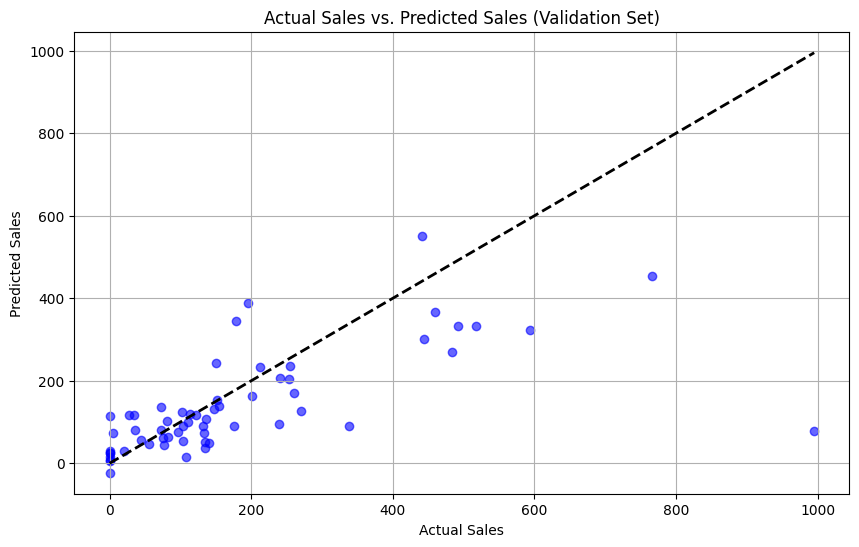

In [112]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, final_predictions, color='blue', alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2) # Diagonal line for perfect predictions
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual Sales vs. Predicted Sales (Validation Set)")
plt.grid(True)
plt.show()

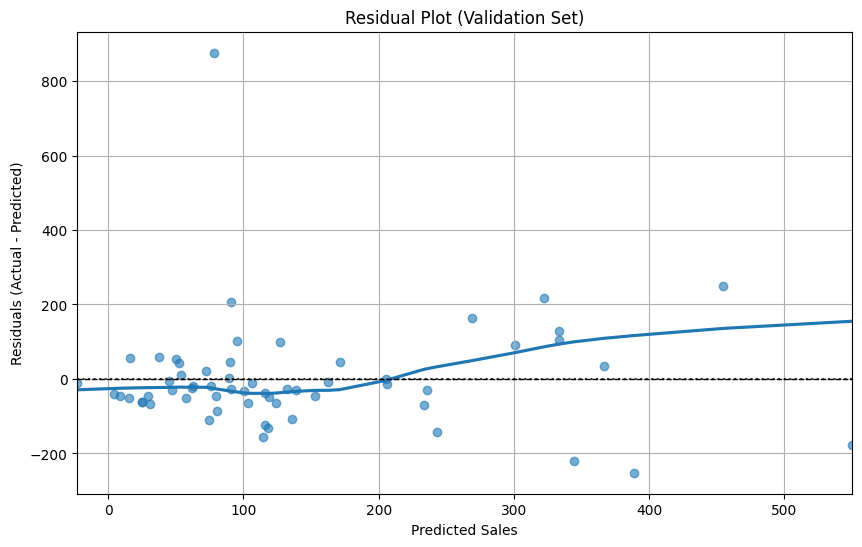

In [113]:
residuals = y_val - final_predictions
plt.figure(figsize=(10, 6))
sns.residplot(x=final_predictions, y=residuals, lowess=True, scatter_kws={'alpha': 0.6})
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (Validation Set)")
plt.axhline(y=0, color='k', linestyle='--', lw=1)
plt.grid(True)
plt.show()

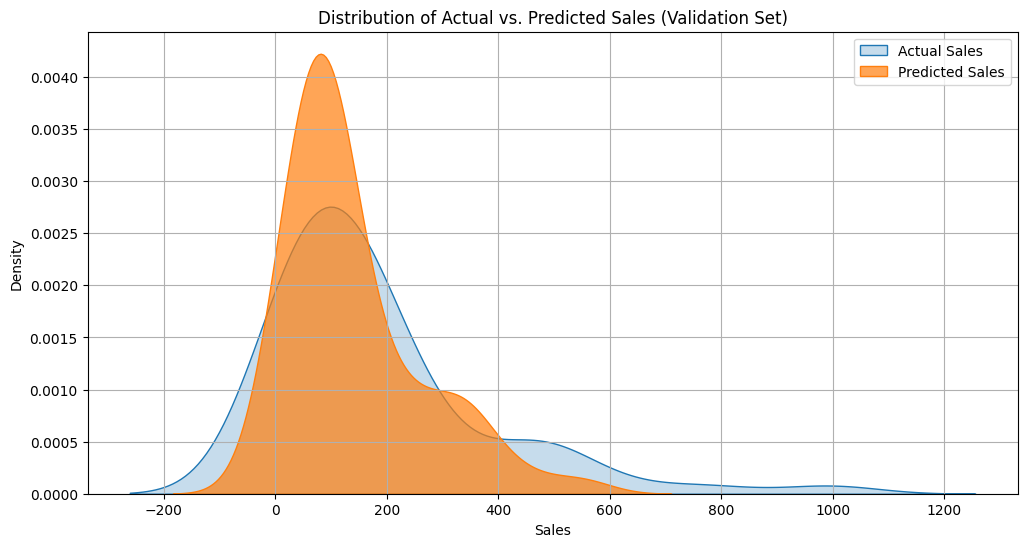

In [114]:
plt.figure(figsize=(12, 6))
sns.kdeplot(y_val, label='Actual Sales', fill=True)
sns.kdeplot(final_predictions, label='Predicted Sales', fill=True, alpha=0.7)
plt.xlabel("Sales")
plt.ylabel("Density")
plt.title("Distribution of Actual vs. Predicted Sales (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='Date'>

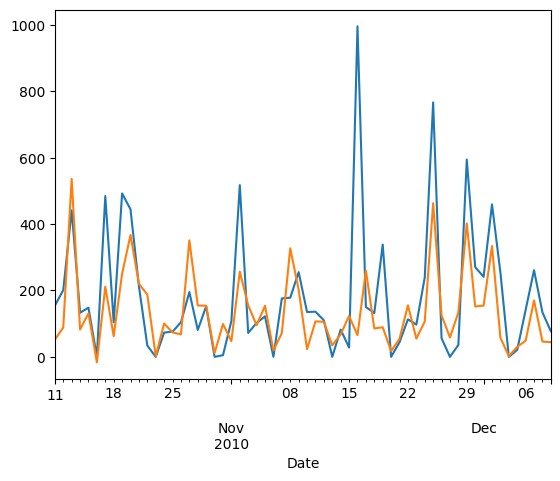

In [107]:
y_val.plot()
final_predictions.plot()

### Train and evaluate models

In [ ]:
features = [
    'AveragePricePerUnitPounds',
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'DayOfMonth',
    'DayBefore',
    'IsWeekend',
    'Rolling3Mean', 'Rolling7Mean',
    'Log1p_AveragePrice',
    'Price_x_IsWeekend'
]

target = 'UnitsSold'

In [123]:
def train_trees(train_df: pd.DataFrame, features: list[str], target: str):
    params = {
        'n_estimators': 605,
        'learning_rate': 0.048214209272824965,
        'max_depth': 4,
        'min_child_weight': 2,
        'subsample': 0.6294234672383359,
        'colsample_bytree': 0.6226867712320926,
        'alpha': 0.40675036841740914,
        'lambda': 0.8752245049302931
    }
    products = train_df['Description'].unique()
    models = dict()
    for product in tqdm(products):
        product_train_df = train_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
        X_train, y_train = product_train_df[features], product_train_df[target]
        models[product] = (
            xgb.XGBRegressor(
                **params,
                objective='reg:squarederror',
                eval_metric='rmse',
                random_state=42)
            .fit(X_train, y_train)
        )
    return models

In [138]:
def get_autoregressive_predictions(
    model: xgb.XGBRegressor,
    prev_values: pd.Series,
    known_future_prices_per_unit: pd.Series,
):
    """
    Performs an autoregressive forecast using an XGBoost model with engineered features.

    Args:
        model: A trained xgb.XGBRegressor.
        prev_values: A Pandas Series of known previous unit sales. Index must be datetime.
        known_future_prices_per_unit: A Pandas Series with the known price of the good
                                      for the forecast dates. Index must be datetime.

    Returns:
        A Pandas Series of predicted unit sales for the future dates.
    """
    values = prev_values.sort_index()
    known_future_prices_per_unit = known_future_prices_per_unit.sort_index()
    results = []

    for date in known_future_prices_per_unit.index:
        price = known_future_prices_per_unit.loc[date]

        day_of_week = date.strftime('%A')  # e.g., 'Monday'
        day_dummies = {
            'Monday': int(day_of_week == 'Monday'),
            'Tuesday': int(day_of_week == 'Tuesday'),
            'Wednesday': int(day_of_week == 'Wednesday'),
            'Thursday': int(day_of_week == 'Thursday'),
            'Friday': int(day_of_week == 'Friday'),
            'Saturday': int(day_of_week == 'Saturday'),
            'Sunday': int(day_of_week == 'Sunday'),
        }

        day_of_month = date.day
        is_weekend = int(date.weekday() >= 5)

        # Handle lags
        day_before = values.get(date - timedelta(days=1), 0)
        rolling_3 = values.loc[(date - timedelta(days=3)):(date - timedelta(days=1))].mean()
        rolling_7 = values.loc[(date - timedelta(days=7)):(date - timedelta(days=1))].mean()

        # Safe handling for log transformation
        log1p_price = np.log1p(price)
        price_x_is_weekend = price * is_weekend

        # Assemble feature vector
        X = pd.DataFrame([{
            'AveragePricePerUnitPounds': price,
            **day_dummies,
            'DayOfMonth': day_of_month,
            'DayBefore': day_before,
            'IsWeekend': is_weekend,
            'Rolling3Mean': rolling_3 if not np.isnan(rolling_3) else 0.0,
            'Rolling7Mean': rolling_7 if not np.isnan(rolling_7) else 0.0,
            'Log1p_AveragePrice': log1p_price,
            'Price_x_IsWeekend': price_x_is_weekend,
        }])

        feature_order = [
            'AveragePricePerUnitPounds',
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
            'DayOfMonth',
            'DayBefore',
            'IsWeekend',
            'Rolling3Mean', 'Rolling7Mean',
            'Log1p_AveragePrice',
            'Price_x_IsWeekend'
        ]
        
        X = X[feature_order]  # Reorder columns

        pred = max(model.predict(X)[0], 0)
        values[date] = pred
        results.append(pred)

    return pd.Series(results, index=known_future_prices_per_unit.index)
        
def get_predictions_for_product(model, all_values, known_future_prices_per_unit, forecast_len = 7):
    all_values = all_values.sort_index()
    known_future_prices_per_unit = known_future_prices_per_unit.sort_index()
    predictions_df = pd.DataFrame(columns=range(1, forecast_len + 1), index=known_future_prices_per_unit.index)
    for date in known_future_prices_per_unit.index:
        end_date = date+timedelta(days=forecast_len)
        preds = get_autoregressive_predictions(
            model,
            all_values.loc[:date],
            known_future_prices_per_unit.loc[date:end_date],
        )
        np.fill_diagonal(predictions_df.loc[date:end_date,:len(preds)].values, preds)
    results_df = predictions_df.copy()
    results_df['observed'] = all_values.loc[known_future_prices_per_unit.index]
    return results_df.reset_index()

def get_predictions(models, train_df, val_df, forecast_len = 7):
    products = val_df['Description'].unique()
    dfs = list()
    for product in tqdm(products):
        if product not in models:
            print(f'Warning: Found no model for "{product}"')
            continue
        model = models[product]
        product_train_df = train_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
        product_val_df = val_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
        all_values = pd.concat([product_train_df['UnitsSold'], product_val_df['UnitsSold']], axis=0).sort_index()
        known_future_prices_per_unit = product_val_df['AveragePricePerUnitPounds'].sort_index()

        results_df = get_predictions_for_product(models[product], all_values, known_future_prices_per_unit)
        results_df.insert(0, 'Product', product)
        dfs.append(results_df.copy())
    return pd.concat(dfs, axis=0, ignore_index=True).reset_index(drop=True)

In [120]:
def calculated_sape_for_row(row, forecast_len = 7):
    numerator = np.abs(row.loc[1:forecast_len] - row.loc['observed'])
    denominator = (np.abs(row.loc[1:forecast_len]) + np.abs(row.loc['observed']))
    sape = numerator / (denominator + 1e-16)
    return sape

In [129]:
models = train_trees(train_df, features, target)

100%|██████████| 196/196 [00:23<00:00,  8.45it/s]


In [139]:
results_df = get_predictions(models, train_df, val_df)
results_df

100%|██████████| 196/196 [02:24<00:00,  1.36it/s]


,Product,Date,1,2,3,4,5,6,7,observed
0,12 pencils small tube red spotty,2010-10-11,0.0,NaN,NaN,NaN,NaN,NaN,NaN,18
1,12 pencils small tube red spotty,2010-10-12,456.754974,482.237366,NaN,NaN,NaN,NaN,NaN,584
2,12 pencils small tube red spotty,2010-10-13,35.521656,35.137691,35.137691,NaN,NaN,NaN,NaN,52
3,12 pencils small tube red spotty,2010-10-14,0.0,68.616989,70.090332,70.090332,NaN,NaN,NaN,49
4,12 pencils small tube red spotty,2010-10-15,7.7878,30.695221,0.184017,1.060187,0.184017,NaN,NaN,55
...,...,...,...,...,...,...,...,...,...,...
11755,zinc metal heart decoration,2010-12-05,22.10194,22.10194,21.946472,11.10423,22.293306,12.377795,7.14496,34
11756,zinc metal heart decoration,2010-12-06,40.85762,66.849434,66.849434,56.452415,26.084757,27.695522,29.236816,33
11757,zinc metal heart decoration,2010-12-07,58.937569,69.304062,75.88446,75.88446,69.027893,72.834213,72.775009,51
11758,zinc metal heart decoration,2010-12-08,26.557867,25.987997,34.715889,33.139835,33.139835,35.971962,34.882301,20


In [140]:
sape_df = results_df.set_index(['Date', 'Product']).apply(calculated_sape_for_row, axis=1).reset_index()
sape_df

,Date,Product,1,2,3,4,5,6,7
0,2010-10-11,12 pencils small tube red spotty,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-10-12,12 pencils small tube red spotty,0.122262,0.095441,NaN,NaN,NaN,NaN,NaN
2,2010-10-13,12 pencils small tube red spotty,0.188277,0.193513,0.193513,NaN,NaN,NaN,NaN
3,2010-10-14,12 pencils small tube red spotty,1.000000,0.166787,0.177095,0.177095,NaN,NaN,NaN
4,2010-10-15,12 pencils small tube red spotty,0.751933,0.283619,0.993331,0.962177,0.993331,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11755,2010-12-05,zinc metal heart decoration,0.212079,0.212079,0.215448,0.507619,0.207959,0.466219,0.652693
11756,2010-12-06,zinc metal heart decoration,0.106389,0.339005,0.339005,0.262178,0.117039,0.087395,0.060466
11757,2010-12-07,zinc metal heart decoration,0.072201,0.152148,0.196119,0.196119,0.150198,0.176318,0.175924
11758,2010-12-08,zinc metal heart decoration,0.140854,0.130208,0.268951,0.247269,0.247269,0.285356,0.271168


In [141]:
smape_df = sape_df.drop(columns=['Date']).groupby('Product').mean()
smape_df

,1,2,3,4,5,6,7
Product,,,,,,,
12 pencils small tube red spotty,0.520620,0.518950,0.502091,0.466713,0.527665,0.506189,0.460028
12 pencils tall tube posy,0.543848,0.548019,0.507373,0.526123,0.506843,0.542789,0.481373
12 pencils tall tube woodland,0.542358,0.529503,0.492029,0.540569,0.510893,0.493500,0.490788
3 stripey mice feltcraft,0.500144,0.441746,0.468123,0.492877,0.514466,0.484804,0.473062
6 ribbons rustic charm,0.389670,0.417009,0.429725,0.370952,0.378085,0.388177,0.377638
...,...,...,...,...,...,...,...
wooden picture frame white finish,0.397170,0.421084,0.345001,0.360585,0.394227,0.417743,0.436003
wooden school colouring set,0.412113,0.377985,0.371608,0.390850,0.391406,0.384698,0.404362
woodland charlotte bag,0.496388,0.482080,0.483166,0.464450,0.438552,0.417649,0.421030


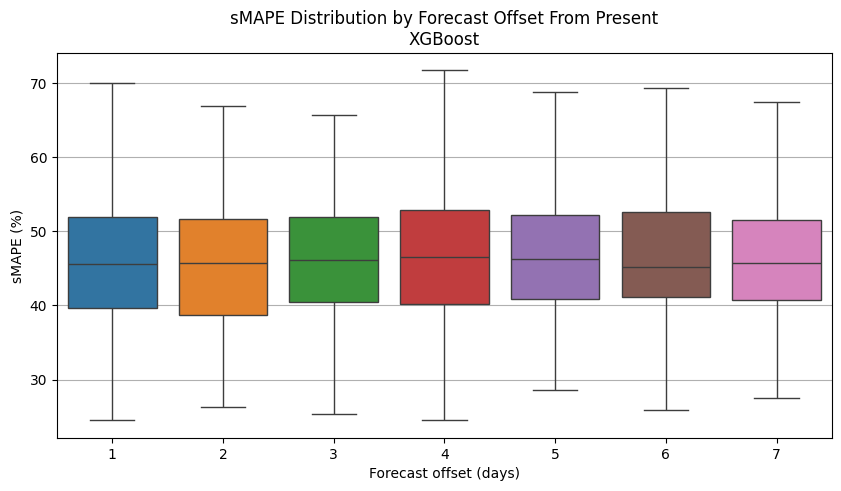

In [146]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=smape_df * 100, showfliers=False, ax=ax)

ax.set_title('sMAPE Distribution by Forecast Offset From Present\nXGBoost')
ax.set_xlabel('Forecast offset (days)')
ax.set_ylabel('sMAPE (%)')
ax.yaxis.grid(True)

In [143]:
smape_df.describe()

,1,2,3,4,5,6,7
count,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,0.470730,0.470573,0.475568,0.480386,0.482952,0.479425,0.480267
std,0.107478,0.109041,0.111918,0.116920,0.119109,0.121248,0.122103
min,0.245792,0.262883,0.253062,0.245166,0.285714,0.258649,0.275071
25%,0.396891,0.387687,0.404713,0.401669,0.408988,0.410848,0.407873
50%,0.455844,0.457720,0.460634,0.465693,0.462983,0.451123,0.457194
75%,0.519105,0.516218,0.519651,0.528080,0.522568,0.526138,0.514800
max,0.987884,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [144]:
q1 = smape_df[1].quantile(0.25)
q3 = smape_df[1].quantile(0.75)

q1_products = smape_df[1][lambda x: x <= q1]
mid_products = smape_df[1][lambda x: (q1 < x) & (x < q3)]
q3_products = smape_df[1][lambda x: x >= q3]

q1_products_sample = q1_products.sample(n=4, replace=False, random_state=42).sort_values()
mid_products_sample = mid_products.sample(n=4, replace=False, random_state=42).sort_values()
q3_products_sample = q3_products.sample(n=4, replace=False, random_state=42).sort_values()

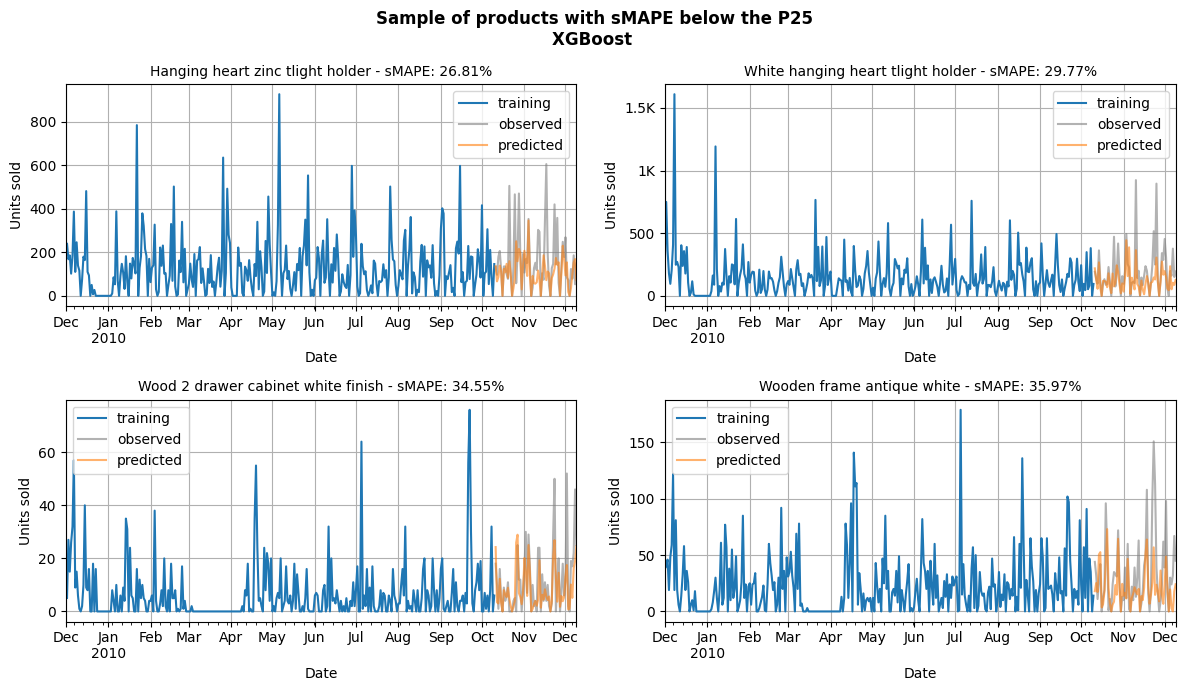

In [147]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

fig.suptitle('Sample of products with sMAPE below the P25\nXGBoost ', fontweight='bold')

for ax, product in zip(axs.flatten(), q1_products_sample.index):
    mape = round(q1_products_sample.loc[product] * 100, 2)

    train_series = train_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    val_series = val_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    pred_series = results_df.query(f'Product == "{product}"').set_index('Date')[1].sort_index()

    train_series.plot(ax=ax, color='tab:blue', label='training')
    val_series.plot(ax=ax, color='tab:grey', alpha=0.6, label='observed')
    pred_series.plot(ax=ax, color='tab:orange', alpha=0.6, label='predicted')

    ax.set_title(f'{product.capitalize()} - sMAPE: {mape:.2f}%', fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Units sold')
    ax.grid(True)
    ax.legend()
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

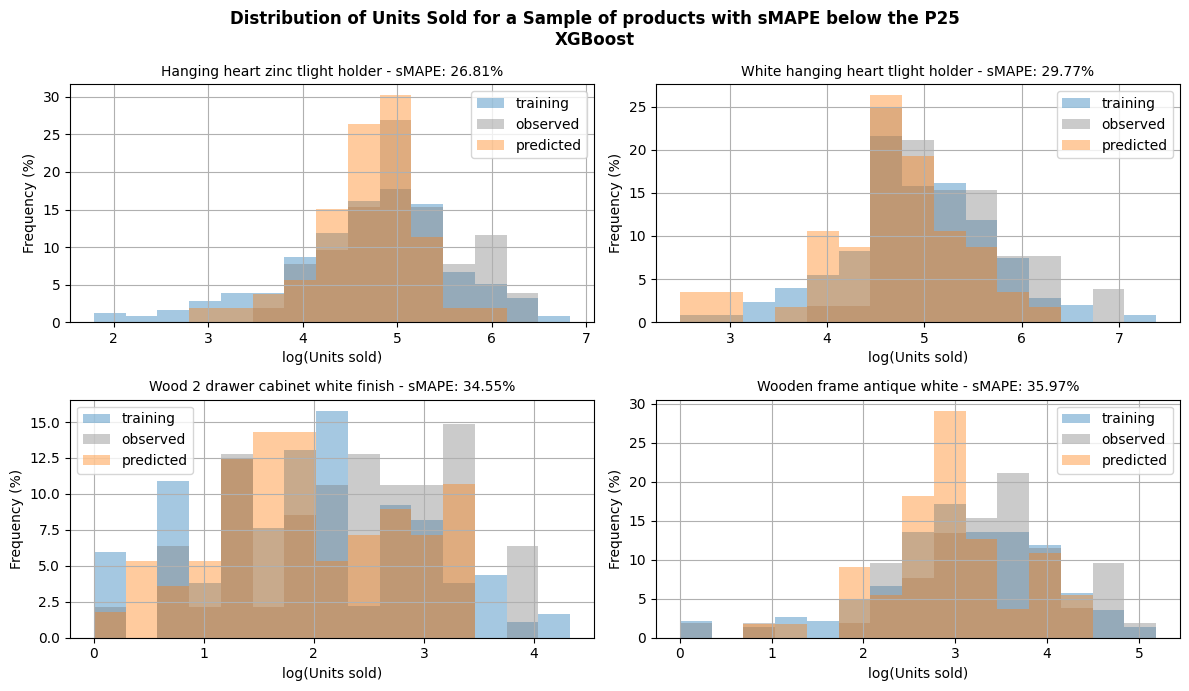

In [148]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

fig.suptitle('Distribution of Units Sold for a Sample of products with sMAPE below the P25\nXGBoost', fontweight='bold')

for ax, product in zip(axs.flatten(), q1_products_sample.index):
    mape = round(q1_products_sample.loc[product] * 100, 2)

    train_series = np.log(train_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index())
    val_series = np.log(val_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index())
    pred_series = np.log(results_df.query(f'Product == "{product}"').set_index('Date')[1].sort_index()[lambda x: x > 0].astype(float))

    # Calculate frequencies for percentage conversion
    train_counts, train_bins = np.histogram(train_series, bins=15)
    train_probs = train_counts / len(train_series) * 100
    val_counts, val_bins = np.histogram(val_series, bins=train_bins) # Use the same bins for comparison
    val_probs = val_counts / len(val_series) * 100
    pred_counts, pred_bins = np.histogram(pred_series, bins=train_bins) # Use the same bins for comparison
    pred_probs = pred_counts / len(pred_series) * 100

    ax.bar(train_bins[:-1], train_probs, width=np.diff(train_bins), align='edge', color='tab:blue', alpha=0.4, label='training')
    ax.bar(val_bins[:-1], val_probs, width=np.diff(val_bins), align='edge', color='tab:grey', alpha=0.4, label='observed')
    ax.bar(pred_bins[:-1], pred_probs, width=np.diff(pred_bins), align='edge', color='tab:orange', alpha=0.4, label='predicted')

    ax.set_title(f'{product.capitalize()} - sMAPE: {mape:.2f}%', fontsize=10)
    ax.set_xlabel('log(Units sold)')
    ax.set_ylabel('Frequency (%)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

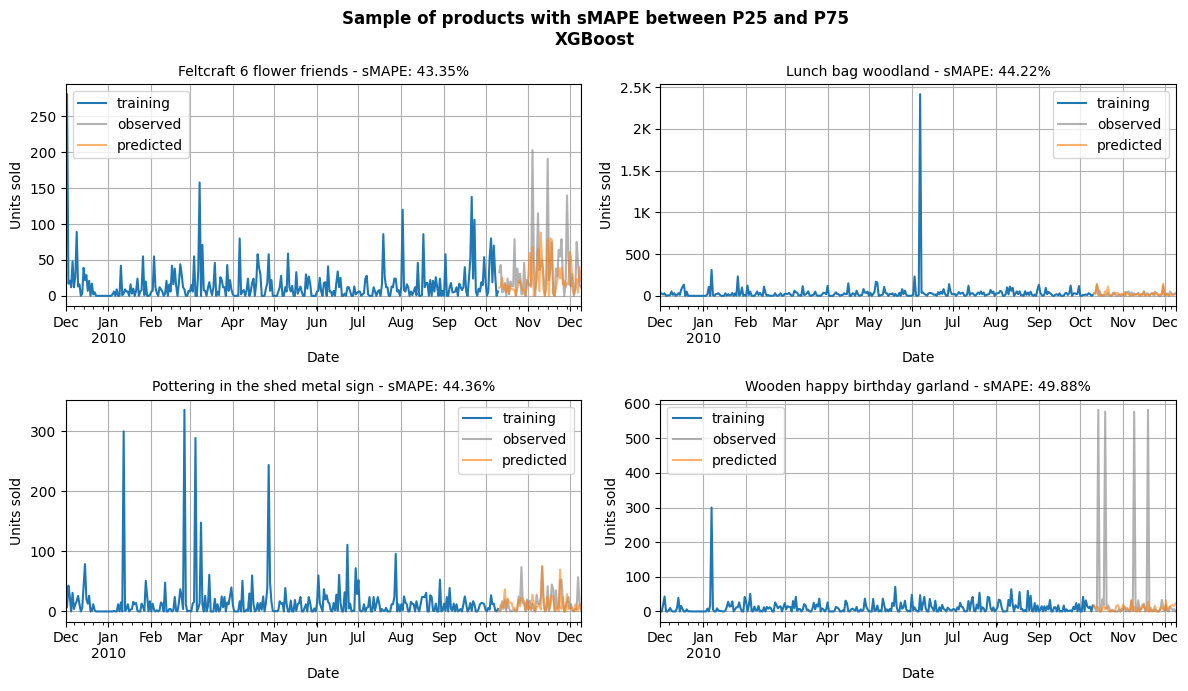

In [149]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

fig.suptitle('Sample of products with sMAPE between P25 and P75\nXGBoost', fontweight='bold')

for ax, product in zip(axs.flatten(), mid_products_sample.index):
    mape = round(mid_products_sample.loc[product] * 100, 2)

    train_series = train_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    val_series = val_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    pred_series = results_df.query(f'Product == "{product}"').set_index('Date')[1].sort_index()

    train_series.plot(ax=ax, color='tab:blue', label='training')
    val_series.plot(ax=ax, color='tab:grey', alpha=0.6, label='observed')
    pred_series.plot(ax=ax, color='tab:orange', alpha=0.6, label='predicted')

    ax.set_title(f'{product.capitalize()} - sMAPE: {mape:.2f}%', fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Units sold')
    ax.grid(True)
    ax.legend()
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

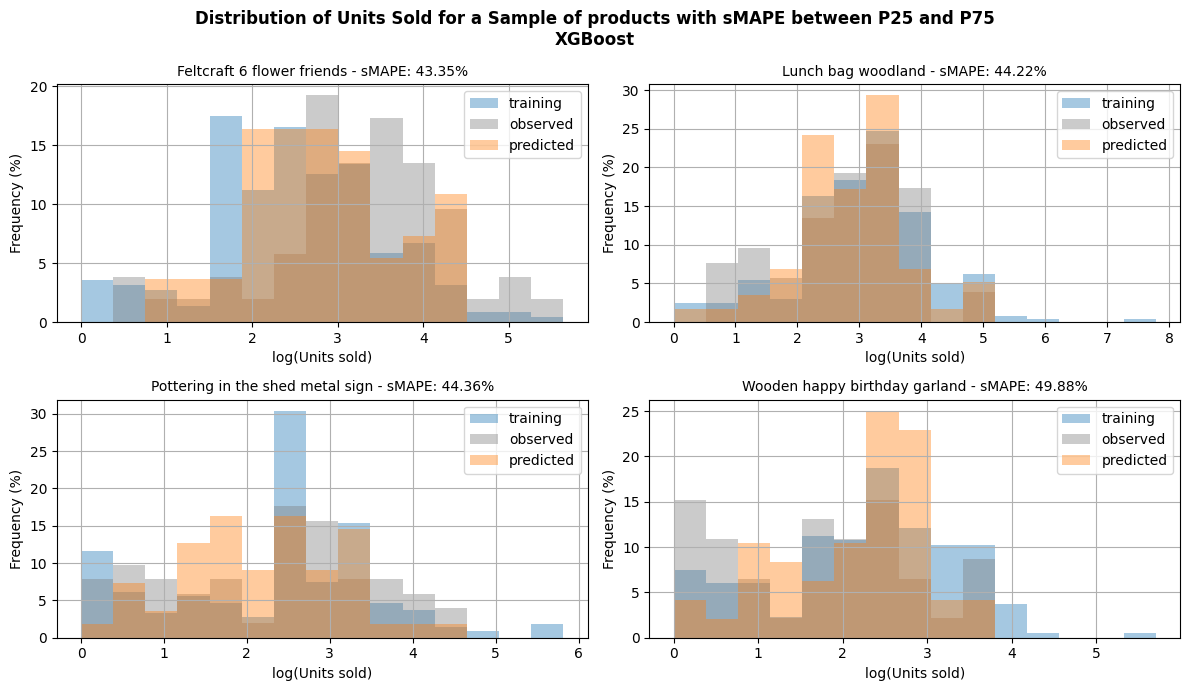

In [150]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

fig.suptitle('Distribution of Units Sold for a Sample of products with sMAPE between P25 and P75\nXGBoost', fontweight='bold')

for ax, product in zip(axs.flatten(), mid_products_sample.index):
    mape = round(mid_products_sample.loc[product] * 100, 2)

    train_series = np.log(train_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index())
    val_series = np.log(val_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index())
    pred_series = np.log(results_df.query(f'Product == "{product}"').set_index('Date')[1].sort_index()[lambda x: x > 0].astype(float))

    # Calculate frequencies for percentage conversion
    train_counts, train_bins = np.histogram(train_series, bins=15)
    train_probs = train_counts / len(train_series) * 100
    val_counts, val_bins = np.histogram(val_series, bins=train_bins) # Use the same bins for comparison
    val_probs = val_counts / len(val_series) * 100
    pred_counts, pred_bins = np.histogram(pred_series, bins=train_bins) # Use the same bins for comparison
    pred_probs = pred_counts / len(pred_series) * 100

    ax.bar(train_bins[:-1], train_probs, width=np.diff(train_bins), align='edge', color='tab:blue', alpha=0.4, label='training')
    ax.bar(val_bins[:-1], val_probs, width=np.diff(val_bins), align='edge', color='tab:grey', alpha=0.4, label='observed')
    ax.bar(pred_bins[:-1], pred_probs, width=np.diff(pred_bins), align='edge', color='tab:orange', alpha=0.4, label='predicted')

    ax.set_title(f'{product.capitalize()} - sMAPE: {mape:.2f}%', fontsize=10)
    ax.set_xlabel('log(Units sold)')
    ax.set_ylabel('Frequency (%)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

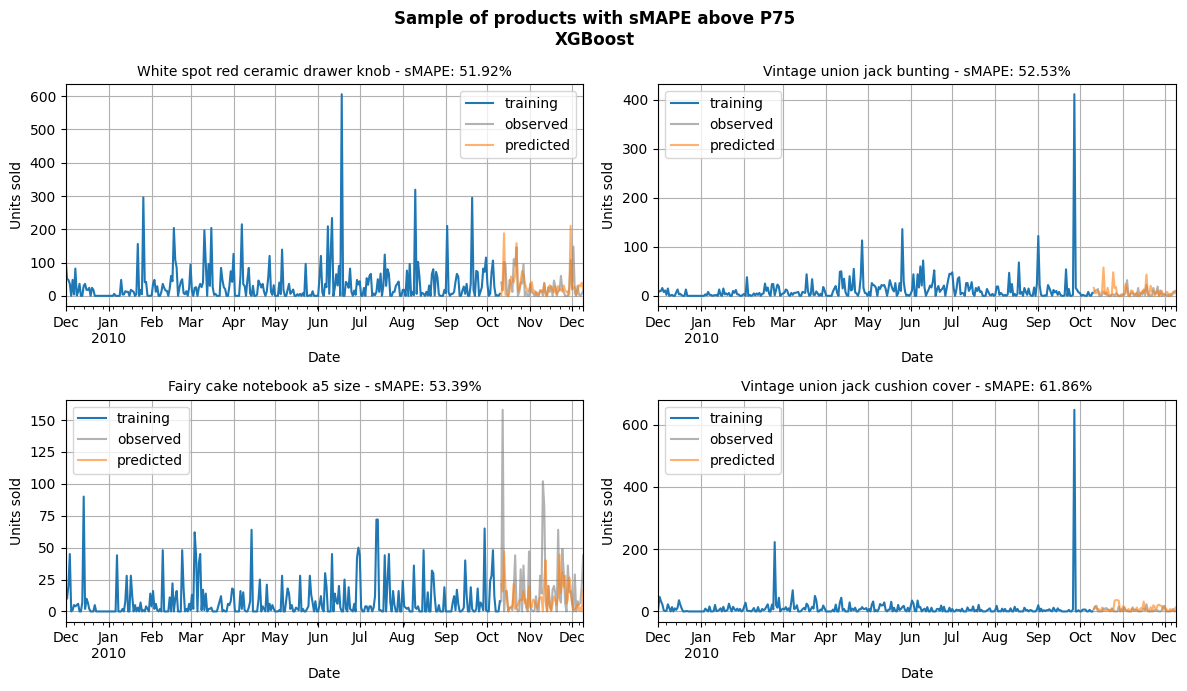

In [152]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

fig.suptitle('Sample of products with sMAPE above P75\nXGBoost', fontweight='bold')

for ax, product in zip(axs.flatten(),q3_products_sample.index):
    mape = round(q3_products_sample.loc[product] * 100, 2)

    train_series = train_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    val_series = val_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    pred_series = results_df.query(f'Product == "{product}"').set_index('Date')[1].sort_index()

    train_series.plot(ax=ax, color='tab:blue', label='training')
    val_series.plot(ax=ax, color='tab:grey', alpha=0.6, label='observed')
    pred_series.plot(ax=ax, color='tab:orange', alpha=0.6, label='predicted')

    ax.set_title(f'{product.capitalize()} - sMAPE: {mape:.2f}%', fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Units sold')
    ax.grid(True)
    ax.legend()
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

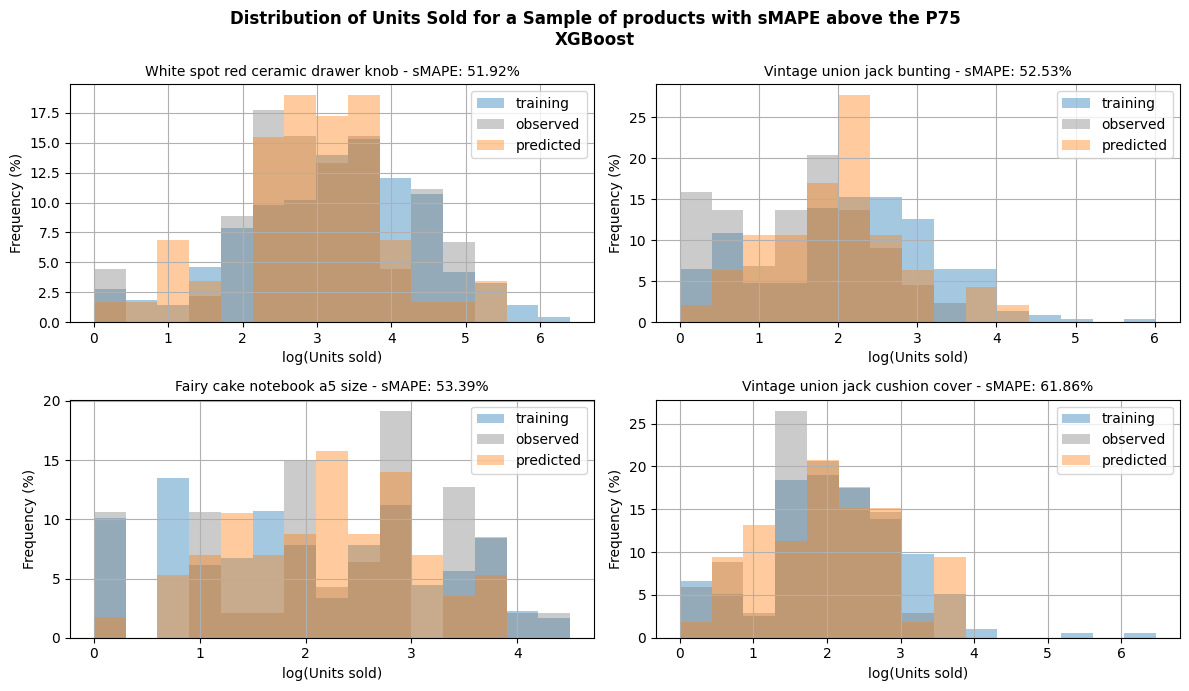

In [155]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

fig.suptitle('Distribution of Units Sold for a Sample of products with sMAPE above the P75\nXGBoost', fontweight='bold')

for ax, product in zip(axs.flatten(), q3_products_sample.index):
    mape = round(q3_products_sample.loc[product] * 100, 2)

    train_series = np.log(train_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index())
    val_series = np.log(val_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index())
    pred_series = np.log(results_df.query(f'Product == "{product}"').set_index('Date')[1].sort_index()[lambda x: x > 0].astype(float))

    # Calculate frequencies for percentage conversion
    train_counts, train_bins = np.histogram(train_series, bins=15)
    train_probs = train_counts / len(train_series) * 100
    val_counts, val_bins = np.histogram(val_series, bins=train_bins) # Use the same bins for comparison
    val_probs = val_counts / len(val_series) * 100
    pred_counts, pred_bins = np.histogram(pred_series, bins=train_bins) # Use the same bins for comparison
    pred_probs = pred_counts / len(pred_series) * 100

    ax.bar(train_bins[:-1], train_probs, width=np.diff(train_bins), align='edge', color='tab:blue', alpha=0.4, label='training')
    ax.bar(val_bins[:-1], val_probs, width=np.diff(val_bins), align='edge', color='tab:grey', alpha=0.4, label='observed')
    ax.bar(pred_bins[:-1], pred_probs, width=np.diff(pred_bins), align='edge', color='tab:orange', alpha=0.4, label='predicted')

    ax.set_title(f'{product.capitalize()} - sMAPE: {mape:.2f}%', fontsize=10)
    ax.set_xlabel('log(Units sold)')
    ax.set_ylabel('Frequency (%)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [156]:
smape_by_dayofweek = sape_df[['Date', 'Product', 1]].copy()
smape_by_dayofweek['DayOfWeek'] = smape_by_dayofweek['Date'].dt.day_name()
smape_by_dayofweek = smape_by_dayofweek.groupby(['DayOfWeek', 'Product'])[1].mean() * 100
smape_by_dayofweek = smape_by_dayofweek.reset_index()
smape_by_dayofweek = smape_by_dayofweek.rename(columns={1: 'sMAPE'})

smape_by_dayofweek

,DayOfWeek,Product,sMAPE
0,Friday,12 pencils small tube red spotty,49.513834
1,Friday,12 pencils tall tube posy,53.537425
2,Friday,12 pencils tall tube woodland,58.025942
3,Friday,3 stripey mice feltcraft,50.105403
4,Friday,6 ribbons rustic charm,39.354711
...,...,...,...
1367,Wednesday,wooden picture frame white finish,25.967401
1368,Wednesday,wooden school colouring set,29.556348
1369,Wednesday,woodland charlotte bag,36.510201
1370,Wednesday,world war 2 gliders asstd designs,52.258978


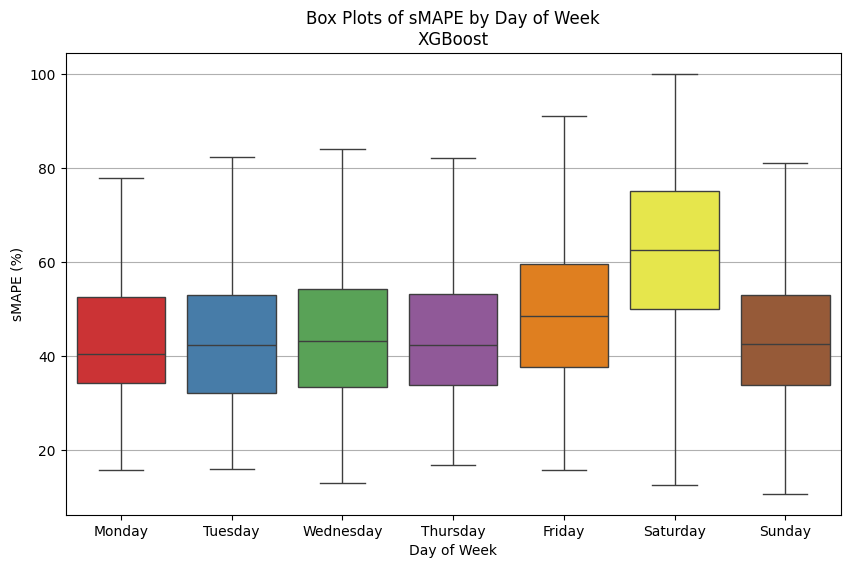

In [158]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='DayOfWeek', y='sMAPE', data=smape_by_dayofweek, order=day_order, showfliers=False, palette='Set1')

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('sMAPE (%)')
plt.title('Box Plots of sMAPE by Day of Week\nXGBoost')
plt.grid(axis='y')

# Show the plot
plt.show()

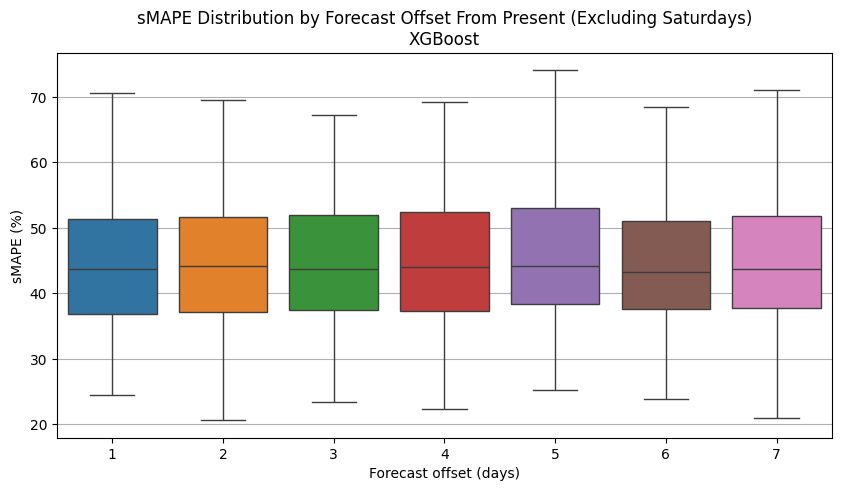

In [162]:
sape_no_sat_df = sape_df[pd.to_datetime(sape_df['Date']).dt.dayofweek != 5]
smape_no_sat_df = sape_no_sat_df.drop(columns=['Date']).groupby('Product').mean()

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=smape_no_sat_df * 100, showfliers=False, ax=ax)

ax.set_title('sMAPE Distribution by Forecast Offset From Present (Excluding Saturdays)\nXGBoost')
ax.set_xlabel('Forecast offset (days)')
ax.set_ylabel('sMAPE (%)')
ax.yaxis.grid(True)